### Project Report 3: Mechanics of a Falling Object
#### Author: Laird Stewart
#### Date: March 26, 2020
#### Other group members: None
#### Summary:
In this project I first model a falling object in a fluid with resistance. I then use the general model I created to try and find the fluid density and resistance constants of a real world problem being given the position vs. time data of the falling object. After finding these constants, I can use my model to fit the data with my own differential equation. I also fit the given data with four different polynomials. 

The model of this falling object that I create will be deterministic, dynamic (the data we are fitting involves time and trajectories), well-mixed (assuming uniform densities), and continuous in time and space. Although the data we are given has descrete (time, position) pairings, the model I will be fitting to it will be continuous. 

# Problem analysis
#### Physical considerations
We are assuming that our object is a sphere and is starting at rest with no velocity. We also assume gravity is that of earths ~9.8. We also assume that the ball and fluid are of constantly distributed densities. In a vector diagram of the sysetem downard is positive (so all our positions and velocities are positive). Gravity will point downward while the density of the water and the fluid resistance are negative (point upward). 

#### Coding considerations
There are two main coding problems: 
1. Define the model I develop as a working differential equation.
2. Optimize my model/polynomials to the data to fit the parameter. 

I also have to find guesses of the parameters for part 2, this involves some math and some coding as part of model development, it also actually uses a few polynomial fits to get basic ideas of the data at starting and terminal velocities.  

Solving step 1 is something we have done a good amount of in the previous two chapters. I will define two functions, one that models the differential equation and another that integrates that differential equatoin, turning it into a working function. 

For the second part I will use the built in curve_fit method from scipy. It uses the Levenberg-Marquardt algoritm for optimization which I will not go to in depth here. Using curve fit only takes one line of code, but in many cases requires good guesses of the parameters to begin with to guarantee that it will find a good fit. The majority of the project is contained in the model development section where I find intial guesses for what these parameters may be. 

# Model development

This model will be comprised of two differential equations relating the balls mass and position. They can be derived as such: 

#### Derive System of Differential Equations of the Model

*Gravity Force + Boyancy Force:*  
$$(\rho_{ball}-\rho_{fluid})Vg$$

*Drag Force:*
$$av+bv^2$$

*Sum of Forces = ma:*
$$\sum F = ma $$
$$(\rho_{ball}-\rho_{fluid})Vg - (av+bv^2) = ma$$
$$ a = \frac{dv}{dt}$$
$$(\rho_{ball}-\rho_{fluid})Vg - (av+bv^2) = m\frac{dv}{dt}$$
$$\frac{dv}{dt}=\frac{(\rho_{ball}-\rho_{fluid})Vg - av - bv^2}{m}$$

$$\rho_{ball} = \frac{m}{V}$$

*Equation 1:*
$$\frac{dv}{dt}=\frac{mg-\rho_{fluid}Vg - av - bv^2}{m}$$

*Equation 2:*
$$\frac{dx}{dt} = v$$

#### Find Guesses for a, b, $\rho_{fluid}$

The goal of this project is to fit the parameters of this system to our newly constructed model. But before we start, in order to use the optimizer built into the curve_fit method in scipy, we must provide guesses for the parameters that we want to fit. In this case we can use a variety of mathematical tools to find guesses for a, b, and p_fluid.

At its terminal velocity the acceleration of the ball = 0. Plugging this into our $\sum F$ eqation, we can find a relationship between p_fluid, b, and the terminal velocity. Note that because b scales $v^2$ it will become the dominant term and a will become insignificant. 

$$\frac{dv}{dt}=\frac{mg-\rho_{fluid}Vg - av - bv^2}{m}$$
$$0=mg-\rho_{fluid}Vg - bv_{terminal}^2$$

Now we need to guess the terminal velocity from the data given so we can find a ratio between p_fluid and b. I will take a 1st degree polynomial fit of the data towards the end (where it is linear) so we can approximate the slope. The data and function that I am using here are defined below. 

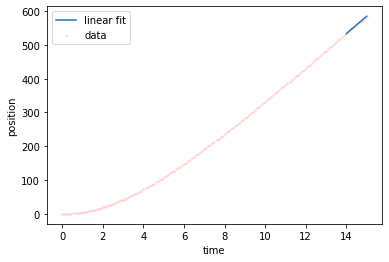

Terminal Velocity: 51.01232636372596


In [140]:
vf_time_data = time_data[140:]
vf_position_data = position_data[140:]

popt1, pcov1 = curve_fit(deg1_poly, vf_time_data, vf_position_data, p0=[10, 10])
a = popt1[0]
b = popt1[1]

plt.plot(vf_time_data, deg1_poly(vf_time_data, a, b), label='linear fit')
plt.scatter(time_data, position_data, label='data', s = 3, alpha = 0.1, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.show()

vel_terminal = b
print("Terminal Velocity: " + str(vel_terminal))

This gives my guess of final velocity: ~50. Now, we can use this value to find a ratio between fluid density and b:
$$0=mg-\rho_{fluid}Vg - bv_{terminal}^2$$

Now if we could find a guess for either fluid density or b we could find a guess for the other. If we examine the $\frac{dv}{dt}$ equation when velocity is small we can remove the drag terms and simplify it: 
$$\frac{dv}{dt}=\frac{mg-\rho_{fluid}Vg - av - bv^2}{m}, v <<$$

$$m\frac{dv}{dt}=mg-\rho_{fluid}Vg$$

$$\rho_{fluid}=\frac{mg-ma}{Vg}$$

Now, like how we found a guess for terminal velocity, if we can find a guess for acceleration when velocity is small (at the beginning of the experiement) we could find a guess for $\rho_{fluid}$. To do this I will find a second detree polynomial fit of the beggining of the data to approximate a second derivative (acceleration) value. 

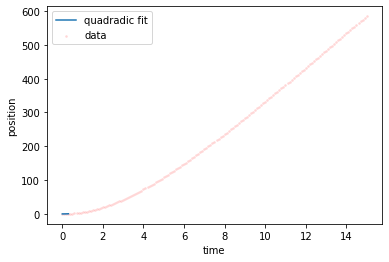

In [141]:
acc_time_data = time_data[0:4]
acc_position_data = position_data[0:4]

popt2, pcov2 = curve_fit(deg2_poly, acc_time_data, acc_position_data, p0=[10, 10, 10])
a = popt2[0]
b = popt2[1]
c = popt2[2]

plt.plot(acc_time_data, deg2_poly(acc_time_data, a, b, c), label='quadradic fit')
plt.scatter(time_data, position_data, label='data', s = 3, alpha = 0.1, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.show()

In [142]:
acc_estimate = 2*c
print("acceleration estimate: " + str(acc_estimate))
m = 0.1
g = 9.8 
V = 0.00014285
p_fluid_estimate = (m*g - m*acc_estimate)/(V*g)
print("fluid desnity guess: " + str(p_fluid_estimate))

acceleration estimate: 9.73771602093496
fluid desnity guess: 4.449078101407991


Now with this fluid density estimate of ~4 we can try to guess b: 
$$0=mg-\rho_{fluid}Vg - bv_{terminal}^2$$

In [143]:
b = (m*g - p_fluid_estimate*V*g)/(vel_terminal**2)
print("b guess: " + str(b))
print("fluid desnity guess: " + str(p_fluid_estimate))

b guess: 0.0003742026391149796
fluid desnity guess: 4.449078101407991


Now we have guesses for b and $\rho_{fluid}$. 'a' is much harder to find a guess for either with the math or with the given data. For the purpose of this experiment I will just use b as a guess for a because I don't think its entirely out of the ballpark to say that v and $v^2$ coeficients are simmilar in magnitude. Later while doing the fitting, it is clear that this shouuld be ok as almost any guess value returns a simmilar a_fit. Now we can get on to the model:

# Model Implementation

In [144]:
# IMPORTING MODULES___________________________________________________________________
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import odeint

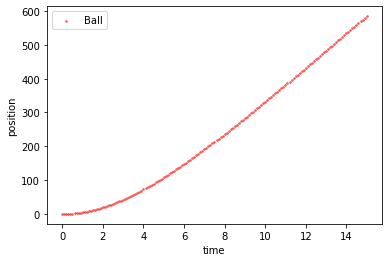

In [145]:
# "BALL" DATA SET LOADING AND PLOTTING________________________________________________
ball = np.loadtxt("/Users/hstewart18/Desktop/ball.txt")
time_data = ball[:, 0]
position_data = ball[:, 1]
plt.scatter(time_data, position_data, label='Ball', s = 3, alpha = 0.5, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.show()

### Define Function of the Model

In [146]:
def falling_ball(x_v, t, a, b, p_fluid): 
    """
    Inputs 
        x_v:      array of current x(position) and v(velocity) values
        p_fluid:  density of fluid 
        a, b:     drag coeficients 
    Output 
        [dX, dV]: current changes in position and velocity with respect to time 
    """
    
    dX = x_v[1]
    dV = (m*g - p_fluid*V*g - a*x_v[1] - b*(x_v[1]**2))/m
    
    return np.array((dX,dV))

In [147]:
def falling_ball_trajectory(t, a, b, p_fluid): 
    return odeint(falling_ball, init_cond, t, args=(a, b, p_fluid))[:, 0]

#note: i take [:, 0] at the end because we only care about position

### Initialize Variables

In [148]:
m = 0.1  # mass kg 
p_ball = 700  # density kg/m^3
V = m/p_ball  # Volume = 0.00014285
V0 = 0  # Initial Velocity 
X0 = 0  # Initial position
g = 9.8  # acceleration due to gravity 
init_cond = np.array((X0,V0))

# a: drag force coeficient (unknown)
# b: drag force coeficient (unkown)
# p_fluid: fluid density (unknown)

### Use curve_fit to find optimized parameter values

In [149]:
a_guess = 0.0003
b_guess = 0.0003
p_fluid_guess = 52  # has to be less dense than the ball

guess_bound = [0, np.inf]
popt, pcov = curve_fit(falling_ball_trajectory, time_data, position_data, p0=(a_guess, b_guess, p_fluid_guess), bounds = guess_bound)
a_fit = popt[0]
b_fit = popt[1]
p_fluid_fit = popt[2]

#std_error = np.sqrt(np.diag(pcov)) # standard error of my parameter estimates
#print(std_error)

print("a_fit: " + str(a_fit))
print("b_fit: " + str(b_fit))
print("p_fluid_fit: " + str(p_fluid_fit))

a_fit: 0.00026611188266238944
b_fit: 0.0003658912727057982
p_fluid_fit: 7.085328824634153e-13


### Plug these fitted parameters into my model and plot

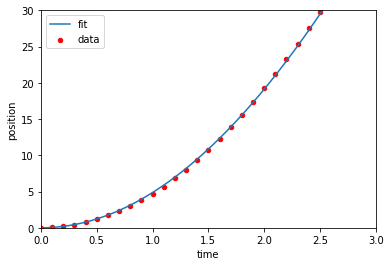

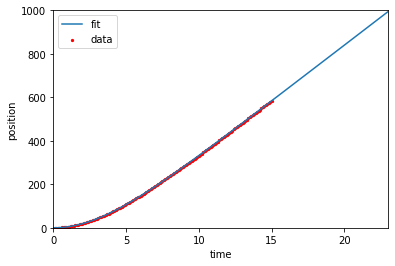

In [150]:
SimulationTime = 30
dt = 0.01
t = np.arange(0.0, SimulationTime+dt, dt)

fit_data = odeint(falling_ball, init_cond, t, args=(a_fit, b_fit, p_fluid_fit))

plt.plot(t, fit_data[:,0], label='fit')
plt.scatter(time_data, position_data, label='data', s = 20, alpha = 1, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.xlim(0, 3)
plt.ylim(0, 30)
plt.show()

plt.plot(t, fit_data[:,0], label='fit')
plt.scatter(time_data, position_data, label='data', s = 5, alpha = 1, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.xlim(0, 23)
plt.ylim(0, 1000)
plt.show()

### Fitting Polynomials to the data

In [151]:
def deg1_poly(x, a, b): 
    return a + b*x

def deg2_poly(x, a, b, c): 
    return a + b*x + c*x**2

def deg3_poly(x, a, b, c, d): 
    return a + b*x + c*x**2 + d*x**3

def deg4_poly(x, a, b, c, d, e): 
    return a + b*x + c*x**2 + d*x**3 + e*x**4


popt1, pcov1 = curve_fit(deg1_poly, time_data, position_data, p0=[10, 10])
a1 = popt1[0]
b1 = popt1[1]


popt2, pcov2 = curve_fit(deg2_poly, time_data, position_data, p0=[10, 10, 10])
a2 = popt2[0]
b2 = popt2[1]
c2 = popt2[2]

popt3, pcov3 = curve_fit(deg3_poly, time_data, position_data, p0=[10, 10, 10, 10])
a3 = popt3[0]
b3 = popt3[1]
c3 = popt3[2]
d3 = popt3[3]

popt4, pcov4 = curve_fit(deg4_poly, time_data, position_data, p0=[10, 10, 10, 10, 10])
a4 = popt4[0]
b4 = popt4[1]
c4 = popt4[2]
d4 = popt4[3]
e4 = popt4[4]

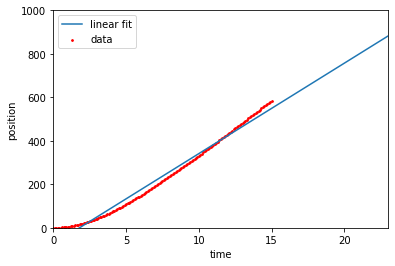

In [11]:
# First Degree polynomial
plt.plot(t, deg1_poly(t, a1, b1), label='linear fit')
plt.scatter(time_data, position_data, label='data', s = 3, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.xlim(0, 23)
plt.ylim(0, 1000)
plt.show()

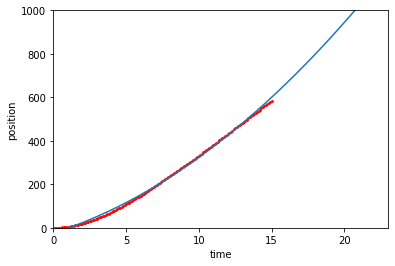

In [12]:
# Second Degree polynomial
plt.plot(t, deg2_poly(t, a2, b2, c2), label='quadratic fit')
plt.scatter(time_data, position_data, label='data', s = 3, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.xlim(0, 23)
plt.ylim(0, 1000)
plt.show()

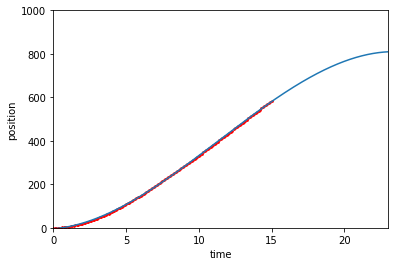

In [13]:
# Third Degree polynomial
plt.plot(t, deg3_poly(t, a3, b3, c3, d3), label='cubic fit')
plt.scatter(time_data, position_data, label='data', s = 3, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.xlim(0, 23)
plt.ylim(0, 1000)
plt.show()

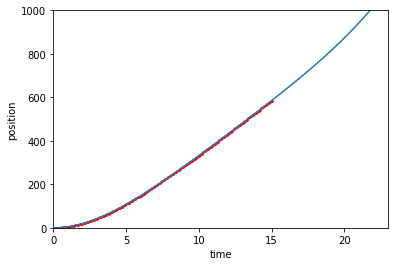

In [14]:
# Fourth Degree polynomial
plt.plot(t, deg4_poly(t, a4, b4, c4, d4, e4), label='cubic fit')
plt.scatter(time_data, position_data, label='data', s = 3, c = "red")
plt.xlabel('time')
plt.ylabel('position')
plt.xlim(0, 23)
plt.ylim(0, 1000)
plt.show()

# Model Verification

My use of curve_fit and odeint does not need to be verified, but I do need to verify that my differential equation solving function that I defined works as I would expect. Also, seeing that my original guess for b was close to the optimized computed value is a step of verification.

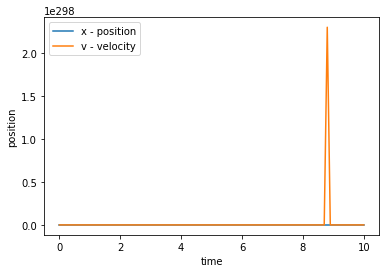

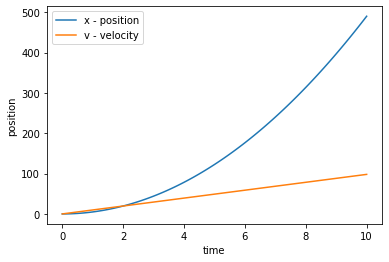

In [114]:
SimulationTime = 10.0
dt = 0.1
t = np.arange(0.0, SimulationTime+dt, dt)
#________________________________________________________________________________________________
# If fluid is more dense than the ball it will not sink
p_ball = 100
p_fluid = 200 
V = m / p_ball
g = 9.8
a = 0.1
b = 0.1 
m = 0.1 
init_cond = np.array((0, 0))
x = odeint(falling_ball, init_cond, t, args=(a, b, p_fluid))
plt.plot(t, x[:,0], label='x - position')
plt.plot(t, x[:,1], label='v - velocity')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.show() # this produces erratic results, not sure why, but either way the velocity is 0 generally
# for the purpose I don't need this function to work under these crazy edge cases so I wont worry about it

#________________________________________________________________________________________________
# If there is no resistance of any kind there will be no terminal velocity
p_ball = 100
p_fluid = 0
V = m / p_ball
g = 9.8
a = 0
b = 0
m = 1.0
init_cond = np.array((0, 0))
y = odeint(falling_ball, init_cond, t, args=(a, b, p_fluid))
plt.plot(t, y[:,0], label='x - position')
plt.plot(t, y[:,1], label='v - velocity')
plt.xlabel('time')
plt.ylabel('position')
plt.legend()
plt.show() # the velocity slope is constant --> constant acceleration due to gravity 

# Discussion

##### What are the final fitted parameters. Do they make sense?
a_fit: 0.00026611188266238944

b_fit: 0.0003658912727057982 

p_fluid_fit: 7.085328824634153e-13

a and b make sense. b is very close to what my original guess for it would be and a is in the same order of magnitude so that definantely makes sense. My p_fluid_fit however, does not make as much sense I suspect it is not well defined by the data given. 

##### Which fit (polynomial or the model) produces more reasonable extrapolations of the measured position for $t=50\dots 150$ seconds?

The model clearly creates a better fit for $t=50\dots 150$ seconds. My graphs above show this pretty clearly. The linear fit has the wrong slope at the terminal velocity and will always produce the incorect terminal velocity. As for the higher degree polynomial fits, they will either approach infinity or negative infinity in quadratic, cubic, etc. time when the data shows that there should be a constant slope of position (terminal velocity) after a ceartain amount of time. Even though I have not plotted out to t = 150 it is clear from the graphs (and general math knowledge) that they will approach infinity **much** faster than the linear final trajectory of the data. 

Therefore the fit I produced with my model is clearly the best. 

##### Can you guess which fluid is the ball falling in?

- a fit: 0.000266
- b fit: 0.000365
- fluid density guess: ~0-4

my fluid density guess is interesting, depending on how many points I choose for the original quadradic fit (in the model development section) the fluid desnity estimate could range from -8 to 20. (20 being more points, -8 being less) less data points should be more accurate (because velocity is smaller) but a negative value is clearly experimental noise, therefore I am guessing it is inbetween 0 and the next value of 4 $\frac{kg}{m^3}$

$a=6\pi\eta r$ --> $\eta$ is the dynamic viscocity, r is radius

$b=1/2 \rho_{\rm fluid}\pi r^2 c_d$ --> $c_d$ is the drag coefficient ~(0.1, 0.3)



In [126]:
#a = 6*np.pi*n*r
a = 0.000266
m = 0.1
p_ball = 700

V = m/p_ball # volume
r = (V/((4/3)*np.pi))**(1/3)# radius

n = a/(6*np.pi*r)

print(n)

0.0004351537495216364


In [127]:
# b = 0.5*p_fluid*np.pi*(r**2)*c_d
b = 0.000365
p_fluid = 23.5 

c_d = b/(0.5*p_fluid*np.pi*(r**2))
print(c_d)

0.009402201579015716


Given these small values of viscocity and drag, I would guess that the 'fluid' we are dropping the ball in is actually a gas. The density of air is about $1.23 \frac{kg}{m^3}$ at sea level so I am guessing the ball is being dropped through air or some combination of gasses. The dynamic viscocity of air is 1.8e-5

However, the dynamic viscocity of water is 1.79e-3 kg/ms which is much closer to our guess for $\eta$ But the density of water is $1000 \frac{kg}{m^3}$. 

In all, if I had to guess what the ball was falling in I would say air, however I am not quite sure how to interpret the different dynamic viscocities. 
